In [97]:
import cv2
import PyPDF2 as pdfpy
import pdf2image
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import (hough_line, hough_line_peaks)
import skimage
from matplotlib import cm

%matplotlib widget

In [159]:
# Importing PDF file

file = open('merged.pdf', 'rb')
pdf = pdfpy.PdfFileReader(file)
pages = [pdf.getPage(pageNumber) for pageNumber in range(pdf.numPages)]
images = pdf2image.convert_from_path('./merged.pdf')

# Converting first page to image as np array
pixels = np.asarray(images[1])
# pixels = ~pixles
img = np.copy(pixels)

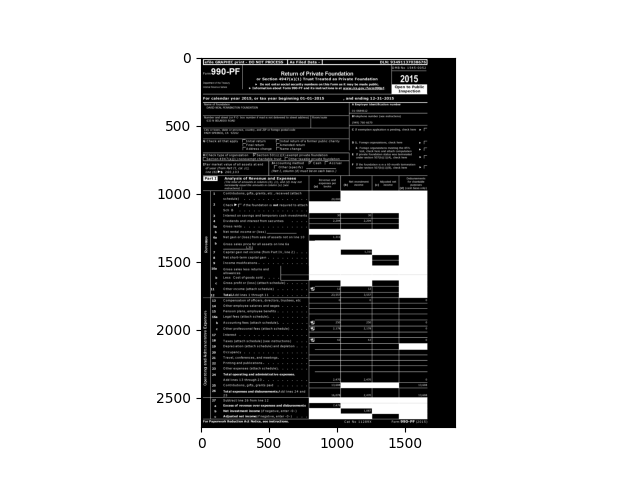

In [160]:
#inverting black and white cuz it makes hough transform more effective

plt.close()
pixels = ~pixels
figures, axes = plt.subplots(1, 1)
plt.imshow(pixels)

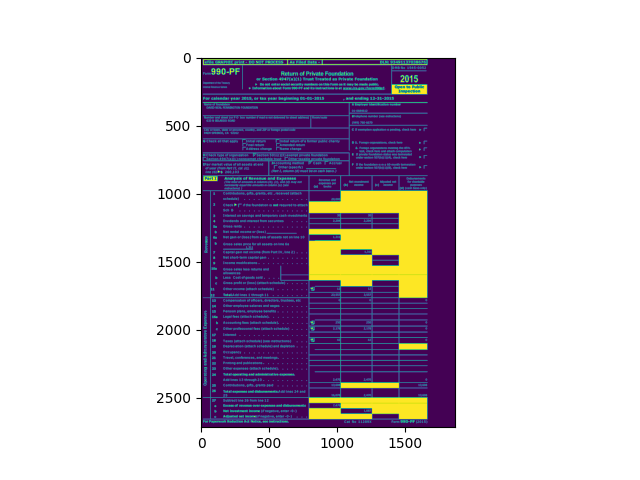

In [161]:
#Converting to Grayscale

gray = skimage.color.rgb2gray(pixels)
imgGray = np.copy(gray)

figures, axes = plt.subplots(1,1)
plt.imshow(gray)

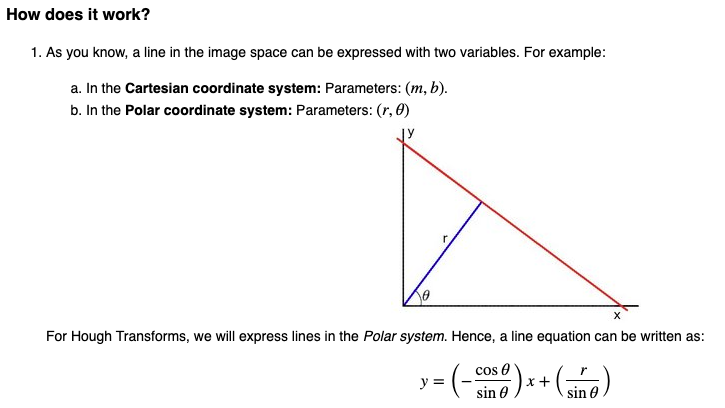

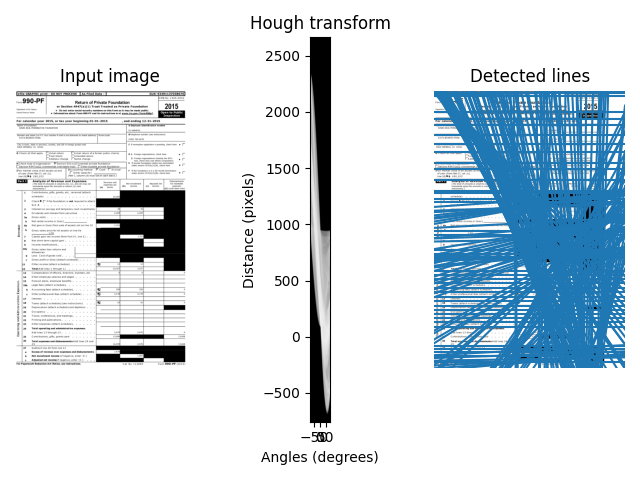

In [163]:
# https://www.youtube.com/watch?v=XRBc_xkZREg

# testes angles for Hough Transform

# Precision = 1 degree if spacing = 180
spacing = 180
tested_angles = np.linspace(-np.pi/2, np.pi/2, spacing)
hspace, theta, dist = hough_line(gray, tested_angles)

# hough line peaks
h, q, d = hough_line_peaks(hspace, theta, dist)


# Generating figure 1
fig, axes = plt.subplots(1, 3)
ax = axes.ravel()

lines_pos = {
    'angle': [],
    'distance' : [],
    'axis': []
}

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + hspace), 
             extent=bounds, 
             cmap=cm.gray, 
             aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)

origin = np.array((0, img.shape[1]))

for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist)):
    # Horizontal lines angle <0 vertical>0
    if dist>0:
        lines_pos['angle'].append(angle)
        lines_pos['distance'].append(dist)
        if angle>0:
            lines_pos['axis'].append('y')
        else:
            lines_pos['axis'].append('x')

        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        y0, y1 = (dist - origin * np.cos(angle)/np.sin(angle) )
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

ax[2].set_xlim(origin)
ax[2].set_ylim((pixels.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')


plt.tight_layout()
# plt.close()

In [152]:
linesDf = pd.DataFrame.from_dict(lines_pos)
linesDf.query("axis=='x'")['distance']

0    1358.0
2    1138.0
3     700.0
4     919.0
5      71.0
Name: distance, dtype: float64

Text(0.5, 1.0, '~gray')

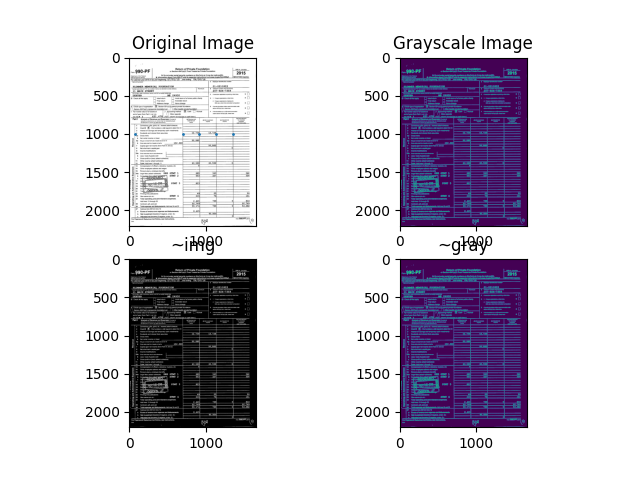

In [158]:
figures, axes = plt.subplots(2, 2)
axes[0, 0].imshow(img)
axes[0, 0].scatter(linesDf.query("axis=='x'")['distance'], [1000 for i in range(5)], s=1)
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(gray)
axes[0, 1].set_title('Grayscale Image')

axes[1, 0].imshow(~img)
axes[1, 0].set_title('~img')

axes[1, 1].imshow(gray)
axes[1, 1].set_title('~gray')


In [141]:
plt.close()
# figures, axes = plt.subplots(1,1)
# plt.imshow(img)